In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
total_data = pd.read_csv('REVIEW.csv',)
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 316352


In [3]:
total_data = total_data.drop('Test', axis=1)

In [4]:
total_data.head()

,Review,Review Code,Score,Store Code (Review),Upload Date,User Id
0,가지마 이거봤으면 가지마,DB000001,1.0,STORE_DB00001,2021-07-27,16d9tp6
1,고기 올려놓고 손님한테 구우라고 하고 화장실감 공기밥 달라고 세번 얘기해야 가져다줌...,DB000002,1.0,STORE_DB00001,2021-07-25,unrrni
2,구워주는 고기집에 고기를 올려놓고 화장실 가고.. 손님한테 구우라는 건 뭔가요? 그...,DB000003,1.0,STORE_DB00001,2021-07-25,qr530u
3,"이동네서는 대형음식점 갈데가 별로 없으니, 배짱식으로 장사하는 곳. 음식 중상, ...",DB000004,2.0,STORE_DB00001,2021-07-17,vel3rk
4,손님말 안듣는 직원들이 근무하는곳이네..,DB000005,1.0,STORE_DB00001,2021-07-17,167lsjl


### 평점이 4, 5인 리뷰에는 레이블 1을, 평점이 1, 2인 리뷰에는 레이블 0을 부여. 부여된 레이블은 새로 생성한 label이라는 열에 저장

In [5]:
total_data['label'] = np.select([total_data.Score > 3], [1], default=0)
total_data[:5]

,Review,Review Code,Score,Store Code (Review),Upload Date,User Id,label
0,가지마 이거봤으면 가지마,DB000001,1.0,STORE_DB00001,2021-07-27,16d9tp6,0
1,고기 올려놓고 손님한테 구우라고 하고 화장실감 공기밥 달라고 세번 얘기해야 가져다줌...,DB000002,1.0,STORE_DB00001,2021-07-25,unrrni,0
2,구워주는 고기집에 고기를 올려놓고 화장실 가고.. 손님한테 구우라는 건 뭔가요? 그...,DB000003,1.0,STORE_DB00001,2021-07-25,qr530u,0
3,"이동네서는 대형음식점 갈데가 별로 없으니, 배짱식으로 장사하는 곳. 음식 중상, ...",DB000004,2.0,STORE_DB00001,2021-07-17,vel3rk,0
4,손님말 안듣는 직원들이 근무하는곳이네..,DB000005,1.0,STORE_DB00001,2021-07-17,167lsjl,0


In [6]:
total_data['Score'].nunique(), total_data['Review'].nunique(), total_data['label'].nunique()

(5, 239626, 2)

In [7]:
#결측값 확인
total_data.isna().sum()

Review                 61296
Review Code                0
Score                  32851
Store Code (Review)        0
Upload Date                0
User Id                91004
label                      0
dtype: int64

In [8]:
#결측치 제거
total_data = total_data.dropna(axis=0)

In [9]:
#결측값 재확인
total_data.isna().sum()

Review                 0
Review Code            0
Score                  0
Store Code (Review)    0
Upload Date            0
User Id                0
label                  0
dtype: int64

In [10]:
# review 열에서 중복인 내용이 있다면 중복 제거
total_data.drop_duplicates(subset=['Review'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 178105


In [11]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 133578
테스트용 리뷰의 개수 : 44527


   label  count
0      0  52365
1      1  81213


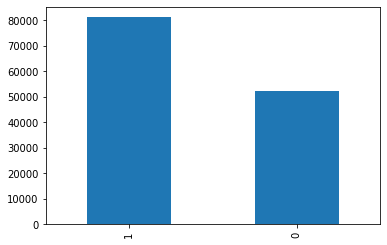

In [12]:
#자료가 불균형함
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [14]:
# 한글과 공백을 제외하고 모두 제거
train_data['Review'] = train_data['Review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['Review'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how='any') # Null 값 제거
print(train_data.isnull().sum())

C:\Users\Amps\anaconda3\envs\multi\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\Amps\anaconda3\envs\multi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Review                 0
Review Code            0
Score                  0
Store Code (Review)    0
Upload Date            0
User Id                0
label                  0
dtype: int64


In [15]:
#테스트 데이터에도 동일한 과정
test_data.drop_duplicates(subset = ['Review'], inplace=True) # 중복 제거
test_data['Review'] = test_data['Review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['Review'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 44425


C:\Users\Amps\anaconda3\envs\multi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Amps\anaconda3\envs\multi\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Amps\anaconda3\envs\multi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing 

In [16]:
# 불용어 처리
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [17]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [19]:
X_train = []
for sentence in train_data['Review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

KeyboardInterrupt: 